# Histopathologic Image Classification Using Convolutiona Neural Network (in PyTorch)
---

# Overview
The notebook documents a computer vision binary classification problem. Specifically, the dataset composes of 220,025x microscopies of 96x96 pixels with corresponding labels indicating whether the center 32x32 region contains metastatic cancer cells. A convolutional neural network of 4x convolutional layers was built using PyTorch and training is done over 10x epochs with various hyperparameters.

ADAM (Adaptive Moment Estimation) was used to optimized the training along with Negative Log Likelihood (NLL) as the loss metric. The rationale for using ADAM and NLL is for their versatility to and ability to adapt to more general classification problems beyond a binary classification problem for future investigations.

The notebook has yet to implemented the desired tuning tool (Ray Tune) as a hyperparameter tuning tool and thus tuning was done manually and thus there are plenty of room for the model's performance. However, undocumented are (1) the experimentation of different CNN filter-size / layers, and (2) data batch-size, prefetch size, number of workers using the PyTorch Dataloader wrapper.

In [ ]:
################################################################################
## INSTALL AND UPGRADE LIBRARIES
################################################################################

## Intall and Upgrade libraries
print("Installing / Upgrading packages...")
!pip install --no-input 'torchinfo==1.8' 

print("#"*80)
print("Done installing! >>> Remember to restart the kernel!!! Else the updates wont be reflected.")
print("#"*80)

## NOTE:
################################################################################
## - When "Save and Run All" using Kaggle, we don't need to restart the kernel, 
##   it seems that Kaggle would miraculously load the installed / upgraded 
##   package. 
## - Just for precaution, there are package version assertions to make sure that
##   the kernel is loading the version needed.

# ## IGNORE - Trick to restart kernel from keyboard
# # Src: https://stackoverflow.com/a/62744676/13697827
# import IPython
# IPython.Application.instance().kernel.do_shutdown(True) # Automatically restarts kernel


################################################################################
## Import Libraries
################################################################################
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import transforms 
from torchvision.transforms import v2 # PyTorch recommends using v2 - https://pytorch.org/vision/main/transforms.html#v1-or-v2-which-one-should-i-use
import torchinfo
import torch.nn as nn
import torch.nn.functional as func
from pathlib import Path
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import datetime as dt
import os, sys, psutil, time, pickle, json

## IGNORE - Checks
print(f"Current working directory: {os.getcwd()}")
print(f"CPU Core count (physical): {psutil.cpu_count(logical=False)}")
print(f"CUDA availability: {torch.cuda.is_available()}")

## Silence warnings
torchvision.disable_beta_transforms_warning()


In [ ]:
################################################################################
## HELPER FUNCTION - Plot the training and validation loss for each epoch
################################################################################

def plot_results(config, training_loss, validation_loss, filename_path):
    """Helper Function: Plot and save the train/validation loss average over epochs."""
    print_textbox = False
    if print_textbox: textbox_text = "\n".join(  "=".join((key, str(value))) for (key, value) in config.items()  )
    
    training_loss = np.mean(training_loss, axis=1)
    validation_loss = np.mean(validation_loss, axis=1)
    
    fig, ax = plt.subplots(1, 1)
    ax.plot(training_loss, 
            linestyle="dashed", 
            linewidth=2, 
            alpha=0.5,
            label="Training Loss (avg per epoch)")
    ax.scatter(x=range(len(training_loss)),
               y=training_loss)
    ax.plot(validation_loss, 
            linestyle="dashed", 
            linewidth=2, 
            alpha=0.5,
            label="Validation Loss (avg per epoch)")
    ax.scatter(x=range(len(validation_loss)), 
               y=validation_loss)

    ax.set_title(f"Training/Validation Loss of Trial: {config['trial_name']}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    if print_textbox: 
        ax.text(0.9, 0.1, textbox_text, fontsize=12, 
            transform=ax.transAxes,
            verticalalignment="bottom",
            horizontalalignment="right", 
            bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.5))
    ax.legend()
    
    fig.show()
    fig.savefig(Path(filename_path))
    return

################################################################################
## HELPER FUNCTION - Calculate conv layer input and outputs dimensions
################################################################################

def calc_dim(height:int, width:int, conv_layer:torch.nn):
    """Calculate the output dimensions for convolutional layers."""
    
    ## Case checking - Sometimes the values can be returned as int instead of a tuple
    kernel_h, kernel_w = (
        (conv_layer.kernel_size, conv_layer.kernel_size) if isinstance(conv_layer.kernel_size, int) 
        else conv_layer.kernel_size
    )
    
    padding_h, padding_w = (
        (conv_layer.padding, conv_layer.padding) if isinstance(conv_layer.padding, int) 
        else conv_layer.padding
    )
    
    stride_h, stride_w = (
        (conv_layer.stride, conv_layer.stride) if isinstance(conv_layer.stride, int) 
        else conv_layer.stride
    )
    
    dilation_h, dilation_w = (
        (conv_layer.dilation, conv_layer.dilation) if isinstance(conv_layer.dilation, int) 
        else conv_layer.dilation
    )
    
    ## Calculate the output dimensions - Src: https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html
    output_height = int( (height + 2*padding_h - dilation_h*(kernel_h - 1) - 1)/stride_h + 1 )
    output_width = int( (width + 2*padding_w - dilation_w*(kernel_w-1) - 1)/stride_w +1 )
    
    return (output_height, output_width)
    

## IGNORE - Tests
test_conv_layer = nn.Conv2d(3, 3, 5, padding=1)
assert (3, 3) == calc_dim(5, 5, test_conv_layer)

# About the dataset - PatchCamelyon (PCam)
The dataset can be found [here](https://www.kaggle.com/competitions/histopathologic-cancer-detection) provided as part of a Kaggle challenge. As mentioned in the description of this dataset, it was adapted from the PatchCamelyon (PCam) dataset and the duplicates from the original dataset has be removed.

Since the dataset is cleaned (de-duplicate), there is not any cleaning that needed to be done. All labels were cleanly organized in a CSV with corresponding image filename.

# Exploratory Data Analysis (EDA)
Due to the dataset being image data instead of tabular data with dimensions, there is not much we can do in terms of exploratory data analysis without having to process the image using some kind of computer vision techniques.

Instead, the only thing we can do is to analyze the balance of the labels (non-cancer vs cancer). Which we found that there are approximately 46.9% more non-cancerous images than cancerous ones (see bar-chart below).

# Image Processing (Transformation)
The dataset contains images of 96x96 pixels, however, the labels only indicate whether the center 32x32 region contains at least one metastatic cancer cell. The additional pixels ignored in the labeling have the same effect as adding padding around the input images for each CNN convolution layers.

Due to the size of this modified dataset being relatively large (~7GB) for the limited amount of training resource we have on hand, during the image processing (transformation) stage, the image is center-cropped to a 46x46 square, still providing a 14-pixel around the region of interest (32x32), but removes the extra pixels that would only have increased the I/O reading time of our pipeline.

The image processing is done using a pipeline of transformers. The pipeline converts the image to a PyTorch Tensor and normalizes each of the three RGB layers pixel values from range 0-255 to 0-1 for a smoother error surface that facilitates better model convergence.

In future improvements of the model, additional histology images can be generated from this dataset by flipping/rotating the existing images. Since histology images are not limited to specific orientation and can be slice from an organ/organism at any orientation, we would like to ensure that the model is trained on all possible permutation. 

It would also be interesting and beneficial if we are able to provide additional context to the model such as the age of the subject, organ of origin

In [ ]:
################################################################################
## Wrap the TRAIN dataset with PyTorch utility wrapper
################################################################################

class DatasetWrapper_Train(torch.utils.data.Dataset):
    # TODO: Redo the function so that data can be downloaded without being on Kaggle
    
    def __init__(self):
        """PyTorch utility wrapper that provides a consistent interface for our data."""
                
        ## Construct an image transformer
        to_tensor_transformer = transforms.ToTensor()
        center_crop_transformer = v2.CenterCrop(size=(46, 46))
        composite_transformer = transforms.Compose([to_tensor_transformer,  
                                                    center_crop_transformer,
                                                   ])
        self.transformer = composite_transformer
        
        # Gather training data
        cwd = Path.cwd()
        input_path = Path("/kaggle/input/")
        dataset_name = "histopathologic-cancer-detection"
        data_dir = Path(input_path, dataset_name, "train")
        self.list_of_filenames = [file.name for file in data_dir.iterdir()]
        self.list_of_fullpaths = list(data_dir.iterdir())
        self.dataset_size = len(self.list_of_fullpaths)
        
        # Gather labels
        labels_path = Path(input_path, dataset_name, "train_labels.csv")
        labels_df = pd.read_csv(labels_path).set_index("id")
        ## Matching the label with each file name
        self.labels = [labels_df.loc[name[:-4], "label"] for name in self.list_of_filenames]
        self.labels_count = len(self.labels)
        
        
    def __len__(self):
        """Returns the number of data entries."""
        return self.dataset_size
    
    def __getitem__(self, idx): 
        """Get the i-th entry of transformed data.
        
        Args: 
            idx (int): Index of the image and label to get.
        
        Returns:
            (img, label): Transformed image as PyTorch Tensor, label as an int.
        """
        # Src: https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py
        with Image.open(self.list_of_fullpaths[idx]) as image: 
            image_transformed = self.transformer(image)
            label = self.labels[idx]
        return (image_transformed, label)
    
    def get_untransformed(self, idx): 
        """Get the i-th entry of untransformed data.
        
        Args: 
            idx (int): Index of the image and label to get.
        
        Returns:
            (img, label): Untransformed image as a PIL image, label as an int.
        """
        image = Image.open(self.list_of_fullpaths[idx])
        label = self.labels[idx]
        
        return (image, label)

    
## Gather and transform the image
train_dataset = DatasetWrapper_Train()
print(f"training_data_tensor size: {sys.getsizeof(train_dataset)} bytes")


In [ ]:
################################################################################
## Wrap the TEST dataset with PyTorch utility wrapper
################################################################################

class DatasetWrapper_Test(torch.utils.data.Dataset):
    # TODO: Redo the function so that data can be downloaded without being on Kaggle
    
    def __init__(self):
        """PyTorch utility wrapper that provides a consistent interface for our data."""
                
        ## Construct an image transformer
        to_tensor_transformer = transforms.ToTensor()
        center_crop_transformer = v2.CenterCrop(size=(46, 46))
        composite_transformer = transforms.Compose([to_tensor_transformer,  
                                                    center_crop_transformer,
                                                   ])
        self.transformer = composite_transformer
        
        # Gather training data
        cwd = Path.cwd()
        input_path = Path("/kaggle/input/")
        dataset_name = "histopathologic-cancer-detection"
        data_dir = Path(input_path, dataset_name, "test")
        self.list_of_filenames = [file.name for file in data_dir.iterdir()]
#         self.list_of_fullpaths = list(data_dir.iterdir())
        self.list_of_fullpaths = [Path(data_dir, filename) for filename in self.list_of_filenames]
        self.dataset_size = len(self.list_of_fullpaths)
        
        
    def __len__(self):
        """Returns the number of data entries."""
        return self.dataset_size
    
    def __getitem__(self, idx): 
        """Get the i-th entry of transformed data.
        
        Args: 
            idx (int): Index of the image and label to get.
        
        Returns:
            img: Transformed image as PyTorch Tensor
        """
        # Src: https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py
        with Image.open(self.list_of_fullpaths[idx]) as image: 
            image_transformed = self.transformer(image)
        file_id = self.list_of_filenames[idx][:-4]
        return (file_id, image_transformed)
    
    def get_untransformed(self, idx): 
        """Get the i-th entry of untransformed data.
        
        Args: 
            idx (int): Index of the image and label to get.
        
        Returns:
            (img, label): Untransformed image as a PIL image, label as an int.
        """
        image = Image.open(self.list_of_fullpaths[idx])
        file_id = self.list_of_filenames[idx][:-4]
        
        return (file_id, image)

    
## Gather and transform the image
test_dataset = DatasetWrapper_Test()
print(f"testing_data_tensor size: {sys.getsizeof(test_dataset)} bytes")


In [ ]:
################################################################################
## Preview what the transformed images look like
################################################################################

training_set_wrapped = DatasetWrapper_Train()
print(f"Dataset size: {len(training_set_wrapped)}")
border_width = 3
n_row, n_col = 5, 10
colors_set = ["#249A41", "#E92E18"]

## Create the figure
fig, ax = plt.subplots(n_row, n_col, figsize=(n_col*1.3, n_row*1.3), facecolor="#EFEFEF")
fig.suptitle("UNTRANSFORMED Image Preview\n(Green=No-Cancer, Red=Cancer)")


for i in range(n_row):
    for j in range(n_col): 
        idx = n_row * i + j
        image, label = training_set_wrapped.get_untransformed(idx)
        
        ## Show the image
        ax[i, j].imshow(image)
        
        ## Configure the shown image
        ax[i, j].spines[:].set_color(colors_set[label])  # SpinesProxy broadcasts the method call to all spines
        ax[i, j].spines[:].set_linewidth(border_width)   # SpinesProxy broadcasts the method call to all spines
        ax[i, j].set_xticklabels([])
        ax[i, j].set_xticks([])
        ax[i, j].set_yticklabels([])
        ax[i, j].set_yticks([])
        
        ## Add a rectangle patch
        left, bottom, width, height = (32, 32, 32, 32)
        rectangle = plt.Rectangle((left, bottom), width, height, 
                                  facecolor="yellow", alpha=0.2)
        ax[i, j].add_patch(rectangle)

## Matplotlib show
fig.show()


In [ ]:
################################################################################
## Preview what the transformed images look like
################################################################################

training_set_iterator = iter(DatasetWrapper_Train())
border_width = 3
n_row, n_col = 5, 10
colors_set = ["#249A41", "#E92E18"]

## Create the figure
fig, ax = plt.subplots(n_row, n_col, figsize=(n_col*1.3, n_row*1.3), facecolor="#EFEFEF")
fig.suptitle("TRANSFORMED Image Preview\n(Green=No-Cancer, Red=Cancer)")


for i in range(n_row):
    for j in range(n_col): 
        image, label = next(training_set_iterator)  # Fetch the next image
        image = np.transpose(image, [1, 2, 0])      # PyTorch Tensor is in a different ordering, thus need to transpose
        
        ## Show the image
        ax[i, j].imshow(image)
        
        ## Configure the shown image
        ax[i, j].spines[:].set_color(colors_set[label])  # SpinesProxy broadcasts the method call to all spines
        ax[i, j].spines[:].set_linewidth(border_width)   # SpinesProxy broadcasts the method call to all spines
        ax[i, j].set_xticklabels([])
        ax[i, j].set_xticks([])
        ax[i, j].set_yticklabels([])
        ax[i, j].set_yticks([])
        
        ## Add a rectangle patch
        left, bottom, width, height = (7, 7, 32, 32)
        rectangle = plt.Rectangle((left, bottom), width, height, 
                                  facecolor="yellow", alpha=0.2)
        ax[i, j].add_patch(rectangle)

## Matplotlib show
fig.show()


In [ ]:
################################################################################
## Analyze the balance of labels
################################################################################

## Get an instance of the dataloader
training_set = DatasetWrapper_Train()

## Count the number of cancer / no-cancer labels
count_no_cancer = np.count_nonzero(np.equal(training_set.labels, 0))
count_cancer = np.count_nonzero(np.equal(training_set.labels, 1))

## Check
print("No-cancer count: ", count_no_cancer)
print("Cancer count: ", count_cancer)

## Plot bar chart of cancer vs no cancer 
fig, ax = plt.subplots(figsize=(3, 5))
barchart = ax.bar(
    ["no_cancer", "cancer"], [count_no_cancer, count_cancer], 
    color=["#249A41", "#E92E18"],
    width=0.3,
    align="center",
)
ax.bar_label(barchart, labels=[count_no_cancer, count_cancer], padding=1)
ax.set_title("Training Set Label Counts")
ax.text(
    0.3, 122000, f"no_cancer:cancer = {round(count_no_cancer/count_cancer, 3)}", 
    ha="left", va="center",
    wrap=True,
    bbox=dict(facecolor="#EFEFEF", 
              alpha=0.3)
)
fig.show()

In [ ]:
################################################################################
## Train Test Split
################################################################################

def train_test_split(dataset_to_split:torch.utils.data.Dataset, 
                     train_proportion:float=0.8, 
                     random_seed:int=1234, 
                     subset_size:int=None):
    """Split a dataset to train and validation sets.
    
    Args: 
        dataset_to_split (torch.utils.data.Dataset): The dataset to be split.
        train_proportion (float): Proportion of training set, default=0.8.
        random_seed (int): Seed for random generator for reproducibility.
        subset_size (int): If set, the dataset to be split will be truncated to this size.
    
    Returns: 
        (train_set, test_set)
    """
    assert ((train_proportion>0) & (train_proportion<1)), f"Train proportion has to be (0, 1), got {train_proportion}."
    
    if subset_size != None:
        dataset_to_split = torch.utils.data.Subset(dataset_to_split, range(subset_size))
    
    generator1 = torch.Generator().manual_seed(1234)  # To allow reproducibility

    # Split to train/test subsets (including labels)
    train_set, test_set = torch.utils.data.random_split(
        dataset_to_split, 
        [train_proportion, 1-train_proportion], 
        generator=generator1
    )
    
    return (train_set, test_set)

## IGNORE - sanity check
training_set, testing_set = train_test_split(train_dataset)

print(f"The training set has {len(training_set)} entries.")
print(f"The testing set has {len(testing_set)} entries.")
print()

for i, (image, label) in enumerate(training_set): 
    if i > 10: break  # Checking the first few entries
    print(f"Image: {i} | On: {image.device} | Shape: {image.shape} | Label: {label}")
    

# Model Architecture
The model is inspired by the LeNet model where there are multiples of (convolutional layer + pooling) as feature extraction section, followed by two linear layers with log-softmax as final output used as a multi-layer perceptron classifier. The log-softmax provides easy adaptation for when we want to adjust and train the network for more than two classification labels.

## Feature Extraction Section
There are 4x (convolution + ReLU activation + maxpooling) layers each with no-padding and 3x3 filter kernels. Due to how small the region of interest is (32x32), I chose a smaller filter kernel and deepen the model depth as with each increased depth, the field of perception increases thus allowing the model to indirectly capture a larger invariant feature.

## Classification Section
The classification section is composed of two linear layer with a log-softmax as the final output. The benefit of log-softmax is its ability to accomodate for any number of classes thus the model can be easily adapted to classify more than 2 categories.

In [ ]:
################################################################################
## Create a CNN model object
################################################################################

class CustomCNN(nn.Module):
    def __init__(self, input_channels:int=3, input_height:int=46, input_width:int=46):
        super().__init__()  # nn.Module constructor
        
        self.input_channels = input_channels
        self.input_height = input_height
        self.input_width = input_width
        
        ## Create/Define the loss function
        self._loss_function = nn.NLLLoss
        
        ## Create all the layers for the network
        # Layer 1
        self.conv1 = nn.Conv2d(in_channels=input_channels, 
                               out_channels=8, 
                               kernel_size=3, 
                               padding=0)
        self.leak_relu1 = nn.LeakyReLU()  # Activation layer doesn't change the output dimensions
        out_h, out_w = calc_dim(input_height, input_width, self.conv1)
        self.maxpool1 = nn.MaxPool2d(2)
        out_h, out_w = calc_dim(out_h, out_w, self.maxpool1)
                               
        # Layer 2
        self.conv2 = nn.Conv2d(in_channels=self.conv1.out_channels, 
                               out_channels=16, 
                               kernel_size=3, 
                               padding=0)
        self.leak_relu2 = nn.LeakyReLU()
        out_h, out_w = calc_dim(out_h, out_w, self.conv2)
        self.maxpool2 = nn.MaxPool2d(2)
        out_h, out_w = calc_dim(out_h, out_w, self.maxpool2)
        
       # Layer 3
        self.conv3 = nn.Conv2d(in_channels=self.conv2.out_channels, 
                               out_channels=32, 
                               kernel_size=3, 
                               padding=0)
        self.leak_relu3 = nn.LeakyReLU()
        out_h, out_w = calc_dim(out_h, out_w, self.conv3)
        self.maxpool3 = nn.MaxPool2d(2)
        out_h, out_w = calc_dim(out_h, out_w, self.maxpool3)
        
       # Layer 4
        self.conv4 = nn.Conv2d(in_channels=self.conv3.out_channels, 
                               out_channels=64, 
                               kernel_size=3, 
                               padding=0)
        self.leak_relu4 = nn.LeakyReLU()
        out_h, out_w = calc_dim(out_h, out_w, self.conv4)
        self.maxpool4 = nn.MaxPool2d(2)
        out_h, out_w = calc_dim(out_h, out_w, self.maxpool4)

        # Classification Layer 1
        self.flattened_dim = out_h * out_w * self.conv4.out_channels
        self.dense1 = nn.Linear(in_features = self.flattened_dim, 
                                out_features = 100)
        self.leak_relu4 = nn.LeakyReLU()
                               
        # Classification Layer 2
        self.dense2 = nn.Linear(in_features = 100, 
                                out_features = 2)  # Binary classification
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        """Override nn.Module forward method."""
        x = self.conv1(x)
        x = self.leak_relu1(x)
        x = self.maxpool1(x)
                               
        x = self.conv2(x)
        x = self.leak_relu2(x)
        x = self.maxpool2(x)
                               
        x = self.conv3(x)
        x = self.leak_relu3(x)
        x = self.maxpool3(x)
        
        x = self.conv4(x)
        x = self.leak_relu4(x)
        x = self.maxpool4(x)

        x = x.view(-1, self.flattened_dim)  # Flatten the tensor                       
        x = self.dense1(x)
        x = self.leak_relu4(x)
        
        x = self.dense2(x)
        x = self.logsoftmax(x)
        
        return x
    
    def get_optimizer(self, **kwargs):
        """Return the optimizer used by this network."""
        return torch.optim.Adam(self.parameters(), **kwargs)
    
    def get_loss_function(self, **kwargs):
        """Return the loss function used by this network"""
        return self._loss_function(**kwargs)
    
    def show_summary(self):
        """Show the model summary information."""
        return torchinfo.summary(
            self, 
            input_size=(self.input_channels, self.input_height, self.input_width), 
            device=torch.device("cuda" if torch.cuda.is_available() else "cpu").type,
            verbose=0)

## IGNORE - TEST
temp_model = CustomCNN()
temp_model.show_summary()


# Training and Validation
The following function is the main training/validation loop. 
A configuration dictionary is used to specify the hyperparameters of the model along with the number of epochs as the function arguments. After each epoch, a checkpoint is saved locally for later retrieval to continue training or fail-safe if unexpected interruption were to occur.

In [ ]:
################################################################################
## Train the model
################################################################################

def train_the_model(config:dict, n_epochs:int=1, verbose:bool=False, progress_print:bool=False):
    """Training loop that connects everything! See comments for details.

    Args: 
        config (dict): Dictionary holding various parameters for the model
        n_epochs (int): Number of epochs to train and validate.
        verbose (bool): Whether to print out the profiling outputs.
    """

    ## Determine whether to use CPU/GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"|| Using {device} ||")
    
    ## Preparing dataset and train/test split it: 
    dataset_to_split = DatasetWrapper_Train()
    training_set, testing_set = train_test_split(dataset_to_split, train_proportion=0.8)
    
    ## Instantiate a CNN model instance
    model = CustomCNN()       # Model instance
    model = model.to(device)  # Move model to the device
    ## Get the optimizer from model instance
    optimizer = model.get_optimizer(                   # Get the optimizer (ADAM)
        lr=config["lr"],                           # Get the learning rate from Ray Tune config
        betas=(config["beta1"], config["beta2"]),  # Get the beta from Ray Tune config 
        weight_decay=config["weight_decay"],       # Get the weight decay from Ray Tune config
    )
    ## Get te loss func from the model instance
    loss_function = model.get_loss_function(reduction='sum')
    
    ## Create dataloader - for convenience
    training_dataloader = torch.utils.data.DataLoader(
        dataset=training_set, 
        batch_size=config["batch_size"], 
        shuffle=True,
        num_workers=config['dataloader_worker_count'],
        prefetch_factor=config["dataloader_prefetch_factor"],
        drop_last=True,  # The last few data that doesn't form a full batch gets dropped.
    )
    validation_dataloader = torch.utils.data.DataLoader(
        dataset=testing_set, 
        batch_size=config["batch_size"], 
        shuffle=True,
        num_workers=config['dataloader_worker_count'],
        prefetch_factor=config["dataloader_prefetch_factor"],
        drop_last=True,  # The last few data that doesn't form a full batch gets dropped.
    )
    
    training_dataset_size = len(training_dataloader.dataset)
    training_batches_per_epoch = int(training_dataset_size / config['batch_size'])  # Round down because drop_last==True
    
    validation_dataset_size = len(validation_dataloader.dataset)
    validation_batches_per_epoch = int(validation_dataset_size / config['batch_size'])  # Round down because drop_last==True

    ## Various tracker for data output
    track_training_loss     = np.zeros((n_epochs, training_batches_per_epoch), dtype=np.float64)
    track_training_TP_count = np.zeros((n_epochs, training_batches_per_epoch), dtype=np.int64)
    track_training_TN_count = np.zeros((n_epochs, training_batches_per_epoch), dtype=np.int64)
    track_training_FP_count = np.zeros((n_epochs, training_batches_per_epoch), dtype=np.int64)
    track_training_FN_count = np.zeros((n_epochs, training_batches_per_epoch), dtype=np.int64)
    
    track_validation_loss     = np.zeros((n_epochs, validation_batches_per_epoch), dtype=np.float64)
    track_validation_TP_count = np.zeros((n_epochs, validation_batches_per_epoch), dtype=np.int64)
    track_validation_TN_count = np.zeros((n_epochs, validation_batches_per_epoch), dtype=np.int64)
    track_validation_FP_count = np.zeros((n_epochs, validation_batches_per_epoch), dtype=np.int64)
    track_validation_FN_count = np.zeros((n_epochs, validation_batches_per_epoch), dtype=np.int64)

    ### ### ### ### ### IGNORE THIS - Still trying to figure out how to get this to work ### ### ### ### ###
#     ## Restore checkpoint (if something failed) - For Ray Tune
#     loaded_checkpoint = train.get_checkpoint()  # Ray Tune keeps track of where the checkpoints are saved
#     if loaded_checkpoint:
#         with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
#             checkpoint_dict = torch.load(
#                 Path(loaded_checkpoint_dir, "checkpoint.pt")
#             )
#         ## Load the state dict into the model and optimizer
#         model.load_state_dict(checkpoint_dict["model_state_dict"])
#         optimizer.load_state_dict(checkpoint_dict["optimizer_state_dict"])
    
    
    ## Main Training / Validation Loop
    for epoch in tqdm(range(n_epochs), desc="Epochs..."):  # Default to one epoch (because dataset is huge!!!)
        if progress_print: print(f"{epoch} / {n_epochs} ", "#"*50)
        ########## TRAINING PORTION ##########
        total_training_loop_start = time.time()  # Timer
        for batch_idx in tqdm(range(training_batches_per_epoch), desc="TRAINING PORTION"):
            if verbose: start_time = time.time()  # Timer
            if batch_idx == 0:  # Magic of dataloader! 
                data_loader_iter = iter(training_dataloader)
                images, labels = next(data_loader_iter)
            else: 
                images, labels = next(data_loader_iter)
            if progress_print: print(f"{batch_idx} / {training_batches_per_epoch}", "#"*50)  # Timer
            if verbose: print(f"Timer - Load Dataloader batch (Train) : {time.time() - start_time}")  # Timer
            if verbose: start_time = time.time()  # Timer
            images = images.to(device)
            labels = labels.to(device)
            if verbose: print(f"Timer - Move to {device} : {time.time() - start_time}")  # Timer
            #print(f"Images Device: {images.device}, Labels Device: {labels.device}")  # Debug use

            ## Set model to training mode
            if verbose: start_time = time.time()  # Timer
            model.train()
            outputs = model(images)  # Inference: The model outputs are in log(proba) scale
            max_value, max_idx = torch.max(outputs, dim=1)
            prediction = max_idx  # Classification 
            ## Calculate metrics
            loss = loss_function(outputs, labels)  # Calculate the loss
            ## Backprop
            optimizer.zero_grad()  # Zero out the loss gradient - https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam.zero_grad
            loss.backward()        # Back propagate the loss
            optimizer.step()       # Perform a single optimization step - https://pytorch.org/docs/stable/_modules/torch/optim/adam.html#Adam
            if verbose: print(f"Timer - Train+Backprop : {time.time() - start_time}")  # Timer
            ## Update variables
            num_of_batches_trained = batch_idx + 1
            ## Update trackers
            if progress_print: print("Training loss: ", loss.item())  # Debug use
            track_training_loss[epoch, batch_idx] = loss.item()
            track_training_TP_count[epoch, batch_idx] = ((prediction==1) & (labels==1)).sum().item()
            track_training_TN_count[epoch, batch_idx] = ((prediction==0) & (labels==0)).sum().item()
            track_training_FP_count[epoch, batch_idx] = ((prediction==1) & (labels==0)).sum().item()
            track_training_FN_count[epoch, batch_idx] = ((prediction==0) & (labels==1)).sum().item()
        total_training_loop_time = time.time() - total_training_loop_start  # Timer
        print(f"Timer - ENTIRE TRAINING PORTION : {total_training_loop_time}")

        ## Validation Loop
        print("Validation loop")
        total_validation_loop_start = time.time()  # Timer
        for batch_idx in tqdm(range(validation_batches_per_epoch), desc="VALIDATION PORTION"): 
            if verbose: start_time = time.time()  # Timer
            if batch_idx == 0:  # Magic of Dataloader
                data_loader_iter = iter(validation_dataloader)
                images, labels = next(data_loader_iter)
            else: 
                images, labels = next(data_loader_iter)
            if progress_print: print(f"{batch_idx} / {validation_batches_per_epoch}", "#"*50)  # Timer
            if verbose: print(f"Timer - Load Dataloader batch (Validation) : {time.time() - start_time}")  # Timer
            with torch.no_grad():  # No gradient mode
                start_time = time.time()
                images = images.to(device)
                labels = labels.to(device)
                if verbose: print(f"Timer - Move to {device} : {time.time() - start_time}")
                #print(f"Images Device: {images.device}, Labels Device: {labels.device}")  # Debug use
                ## Model inference
                if verbose: start_time =time.time()  # Timer
                outputs = model(images)
                max_value, max_idx = torch.max(outputs, dim=1)
                prediction = max_idx
                if verbose: print(f"Timer - Model inference : {time.time() - start_time}")  # Timer
            ## Calculate metrics
            loss = loss_function(outputs, labels)
            ## Update variables
            num_of_batches_validated = batch_idx + 1
            ## Update trackers
            if progress_print: print("Validation loss: ", loss.item())  # Debug use
            track_validation_loss[epoch, batch_idx] = loss.item()
            track_validation_TP_count[epoch, batch_idx] = ((prediction==1) & (labels==1)).sum().item()
            track_validation_TN_count[epoch, batch_idx] = ((prediction==0) & (labels==0)).sum().item()
            track_validation_FP_count[epoch, batch_idx] = ((prediction==1) & (labels==0)).sum().item()
            track_validation_FN_count[epoch, batch_idx] = ((prediction==0) & (labels==1)).sum().item()
        total_validation_loop_time = time.time() - total_validation_loop_start
        print(f"Timer - ENTIRE VALIDATION PORTION : {total_validation_loop_time}")

        
         ## Collect all the items into dictionary to return
        output = {
            "Training Loss": track_training_loss, 
            "Training TP": track_training_TP_count, 
            "Training FP": track_training_FP_count, 
            "Training TN": track_training_TN_count,
            "Training FN": track_training_FN_count,
            "Validation Loss": track_validation_loss, 
            "Validation TP": track_validation_TP_count, 
            "Validation FP": track_validation_FP_count, 
            "Validation TN": track_validation_TN_count,
            "Validation FN": track_validation_FN_count,
            #"loss": 1, # Dummy loss
        }
        
        ########## CHECKPOINT PORTION ##########
        ## Create checkpoint data to be serialized
        checkpoint_data = {
            "epoch": epoch, 
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }
        ## Define the location to save - Ray Tune changes directory during tuning, thus getcwd() won't be where the usual working dir is.
        dir_path = Path(os.getcwd(),  config['trial_name'], "model_checkpoint")
        print(f"Checkpoint saved to {dir_path}.")
        os.makedirs(dir_path, exist_ok=True)    # Make sure the directory is created
        ## Serialize and save the checkpoint data
        checkpoint_path = Path(dir_path, "checkpoint.pt")
        torch.save(checkpoint_data, checkpoint_path)  # Serialize the checkpoint data
        
        
    ### ### ### ### ### IGNORE THIS - Still trying to figure out how to get this to work ### ### ### ### ###
#         ## Create a Ray Tune session report
#         ## Passes the checkpoint data to Ray Tune
#         report = {
#             "loss": np.mean(track_validation_loss[epoch, :]),
#         }
#         ## Read the serialized checkpoint data from storage - Seemingly redundant step allow us to revert back to lack checkpoint when code fails.
#         checkpoint_from_storage = train.Checkpoint.from_directory(dir_path)  # Convert to Ray Tune checkpoint
#         train.report(report, checkpoint = checkpoint_from_storage)
    
    dir_path = Path(os.getcwd(), config['trial_name'], "output_pickle")
    os.makedirs(dir_path, exist_ok=True)    # Make sure the directory is created
    with open(Path(dir_path, "output.pkl"), "wb") as f: 
        pickle.dump(pickle.dumps(output), f)
   

    plot_results(config, output['Training Loss'], output['Validation Loss'], Path(os.getcwd(), config['trial_name']))
    
    if True:  # Final report
        print(f"Timer - ENTIRE TRAINING PORTION : {total_training_loop_time}")
        print(f"Timer - ENTIRE VALIDATION PORTION : {total_validation_loop_time}")
        print(f"Checkpoint path: {checkpoint_path}")
        print(f"Pickle path: {Path(os.getcwd(), 'output_pickle', 'output.pkl')}")
        
        
    return output

# Hyperparmaeter Tuning
The follow calls to the main training/validation loop passes different configuration dictionaries to test the performance of each hyperparameter combinations. Specifically, it tested different learning rate and weight decay rates.

## Thoughts on each hyperparameter (ADAM)

### Learning rate: 
- Learning rate is would trade-off with training time and work in tandem with the momentum. A very small learning rate would need a larger momentum compared to a larger learning rate.

### Weight decay: 
- Weight decay can be interpreted as a L2 regularization as it penalizes large model coefficients. 
- From interpretation, I prefer these values to be on the smaller end so that each filter is more unique from each other as opposed to having very similar parameters due to the penalization.

### Beta 1 and Beta 2: 
- These parameters can be interpreted as the running average and sqaure of the gradient.
- Defaults are 0.9 and 0.9, which provides a lot of momentum for the optimizer, thus best combined with a small learning rate to prevent overshooting the optimal parameter.

In [ ]:
################################################################################
## Hyperparameter Tuning: 1a
################################################################################

config = {
    "lr": 0.003,
    "beta1": 0.9,
    "beta2": 0.9,
    "weight_decay": 0,
    "batch_size": 50,
    "dataloader_worker_count": 10,
    "dataloader_prefetch_factor": 5000,
    "trial_name": "1a",
}

output = train_the_model(config=config, n_epochs=10, verbose=False)



In [ ]:
################################################################################
## Hyperparameter Tuning: ab (weight decay = 2)
################################################################################

config = {
    "lr": 0.003,
    "beta1": 0.9,
    "beta2": 0.9,
    "weight_decay": 2,
    "batch_size": 50,
    "dataloader_worker_count": 10,
    "dataloader_prefetch_factor": 5000,
    "trial_name": "1b",
}

output = train_the_model(config=config, n_epochs=10, verbose=False)



In [ ]:
################################################################################
## Hyperparameter Tuning: 1c (weight decay = 6)
################################################################################

config = {
    "lr": 0.003,
    "beta1": 0.9,
    "beta2": 0.9,
    "weight_decay": 6,
    "batch_size": 50,
    "dataloader_worker_count": 10,
    "dataloader_prefetch_factor": 5000,
    "trial_name": "1c",
}

output = train_the_model(config=config, n_epochs=10, verbose=False)



In [ ]:
################################################################################
## Hyperparameter Tuning: 2a (learning rate = 0.03)
################################################################################

config = {
    "lr": 0.03,
    "beta1": 0.9,
    "beta2": 0.9,
    "weight_decay": 0,
    "batch_size": 50,
    "dataloader_worker_count": 10,
    "dataloader_prefetch_factor": 5000,
    "trial_name": "2a"
}

output = train_the_model(config=config, n_epochs=10, verbose=False)



In [ ]:
################################################################################
## Hyperparameter Tuning: 2b (learning rate = 0.3)
################################################################################

config = {
    "lr": 0.3,
    "beta1": 0.9,
    "beta2": 0.9,
    "weight_decay": 0,
    "batch_size": 50,
    "dataloader_worker_count": 10,
    "dataloader_prefetch_factor": 5000,
    "trial_name": "2b"
}

output = train_the_model(config=config, n_epochs=10, verbose=False)



# Inferencing the Kaggle Competition Data


The following plot was generated via prior training. The training and validation loss between each of the models in the hyperparameter tuning section differ drastically (in magtitudes), thus, I am confidence to say that out of all the models used for tuning, model 1a is the most optimal solution.

Thus, I load the trained model parameters and inferenced the the competition test set for competition submission

```python
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("/kaggle/working/previous_kernel_output/1a.png")
plt.axis("off")
plt.imshow(img)
```

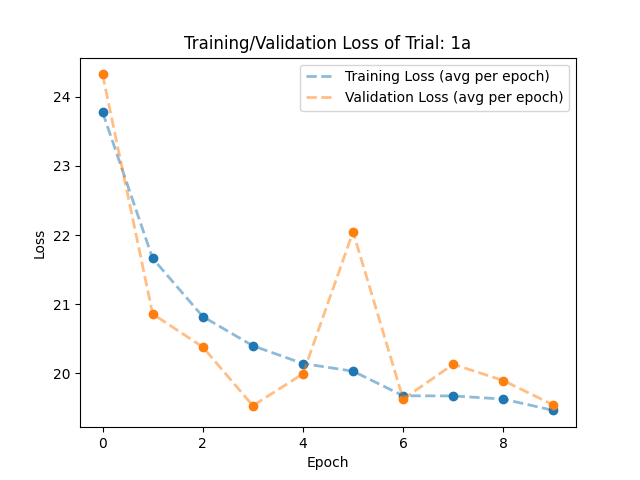

## Load Kaggle-API

The key for the API token has been replaced with dummy values because it is supposed to be kept secret.

```python
## API Token
api_token = {"username":"anthonyylee", 
             "key":"abcd"}  # The real token key is hidden~~ It is supposed to be a secret, so I can't tell you~

api_token_path = Path("/", "root", ".kaggle")
api_token_file = Path(api_token_path, "kaggle.json")
os.makedirs(api_token_path, exist_ok=True)

print(f"api_token_path: {api_token_path}")

## Write api token file
with open(api_token_file, "w") as file: 
    json.dump(api_token, file)

## Change permission and check permission
os.chmod(api_token_file, 0o600)
print( f"Is the token file 600 : { oct(os.stat(api_token_file).st_mode)[-3:] == '600' }" )

```

## Download the output from pervious kernel version

The Kaggle API only supports downloading the latest kernel version's output, thus, the actual results may differ slightly as new versions are continuously added.

```python
## Download previous output files to working directory
!kaggle kernels output anthonyylee/cnn-histopathologic-classification-using-pytorch -p /kaggle/working/previous_kernel_output
```

## Load model state and make inference on the competition test dataset

The best performing model state is loaded and used to make inference on the competition test dataset for submission.

```python
## Load model 1a and make inference using the CNN model

## Load the model state from output file
batch_size = 50
device = 'cuda' if torch.cuda.is_available() else 'cpu'
loaded_checkpoint = torch.load(
    "/kaggle/working/previous_kernel_output/1a/model_checkpoint/checkpoint.pt",  
   map_location=torch.device(device)
)

## IGNORE - checks
assert isinstance(loaded_checkpoint, dict) == True, "Checkpoint loading has some king of error"


## Create model and load the model state
cnn_model = CustomCNN()
cnn_model.load_state_dict(loaded_checkpoint["model_state_dict"])
cnn_model.to(device)

## Fetch the optimizer (ADAM) and load the state
model_optimizer = cnn_model.get_optimizer()
model_optimizer.load_state_dict(loaded_checkpoint["optimizer_state_dict"])

## Inference with model 1a and save results

test_dataloader = torch.utils.data.DataLoader(  # Create a dataloader to make things easier
    dataset = DatasetWrapper_Test(),  # The competition test dataset
    batch_size = batch_size, 
    shuffle = False, 
    num_workers = 10, 
    prefetch_factor = 5000,
    drop_last = False,
)

file_id_holder = []  # Test set is small enough thus holding output in memory
results_holder = np.zeros(shape=(len(test_dataloader), batch_size) )   # Test set is small enough thus holding output in memory
for idx in tqdm(range( len(test_dataloader) ), desc="Inferencing test set"):
    with torch.no_grad():  # No gradient mode
        
        if idx == 0:  # Create an dataloader iterator
            dataloader_iter = iter(test_dataloader)
            
        file_ids, images = next(dataloader_iter)  # Load the next iterator output
        assert len(file_ids) == len(images), "File IDs and images don't have the same number of records."
        images = images.to(device)  # Transfer to GPU for faster inferencing
        
        ## Model inference
        output = cnn_model(images)
        max_value, max_idx = torch.max(output, dim=1)
        predictions = max_idx
        
        ## Append results to holder
        predictions = predictions.cpu().numpy()  # Need to copy to CPU first
        if len(predictions) != batch_size:  # The last batch typically is not a full-sized batch
            predictions = np.pad(predictions, (0, batch_size - len(predictions)), "constant", constant_values=(0))
        results_holder[idx, :] = predictions
        file_id_holder.append(file_ids)
```

## Clean up the inference output for submission

```python
## Reshape the 2D array to an 1D array
file_id_holder_new = list(chain(*file_id_holder))  # Convert list of lists into just list
results_holder_new = results_holder.reshape((-1))[:len(file_id_holder_new)].astype(int)  # Remove the extra padded elements

## IGNORE: Check
assert ( len(results_holder_new) == len(file_id_holder_new)), "The lengths are not the same, something is off."
print(len(results_holder_new))
print(len(file_id_holder_new))



## Save the data in CSV for submission
df = pd.DataFrame({"id":file_id_holder_new, "label":results_holder_new})
df.to_csv("/kaggle/working/submission.csv", index=False)


## IGNORE: Check
read_from_csv = pd.read_csv("/kaggle/working/submission.csv")
read_from_csv.head()
# !cat /kaggle/working/submission.csv
```

## Submit the submission for the competition

```python
## Submit the results to Kaggle
!kaggle competitions submit -c histopathologic-cancer-detection -f /kaggle/working/submission.csv -m "AYL_Submission"
```

## Inference Results

As seen below, my score is far from the top performer, but it is better than 50 / 50 from random guessing.

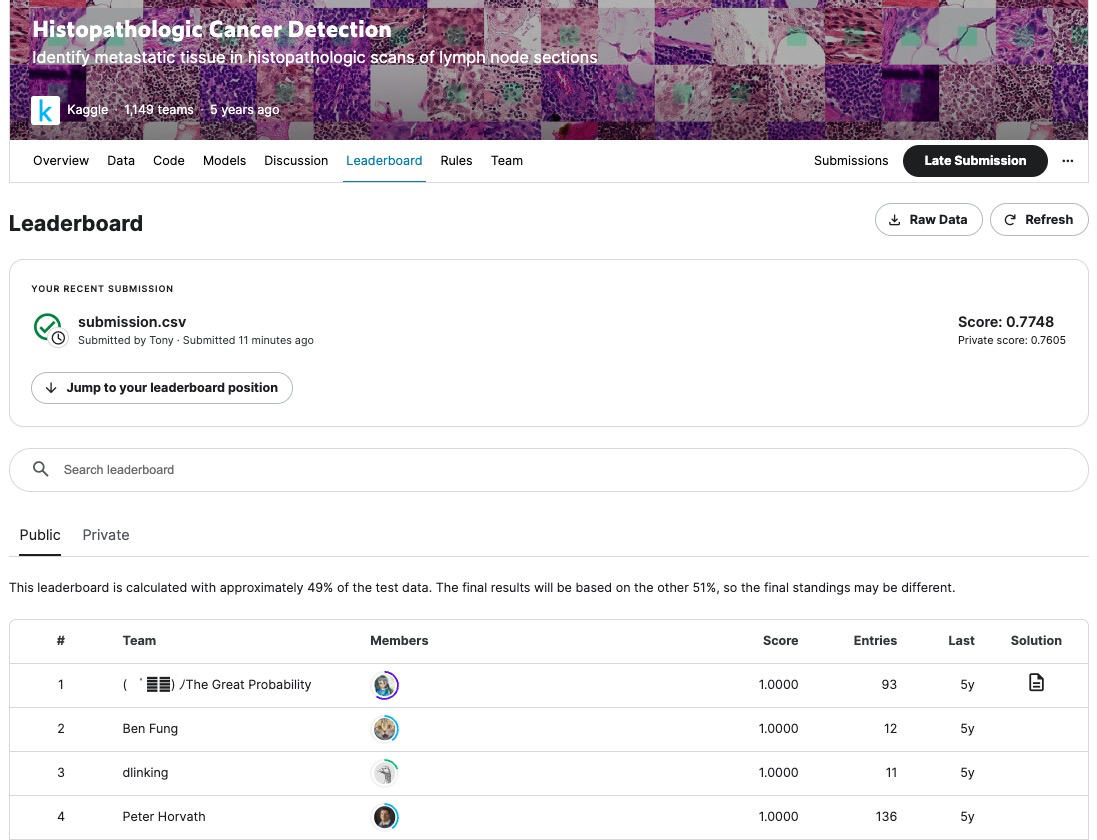

# Final words + Future Improvements

The objective for this notebook for myself is to test the PyTorch framework as it is a framework that I have not utilized before, thus this is my first foray into PyTorch. Compared to TensorFlow, it is a different way of thinking on how to structure my model thus it took a lot of upfront investment in understanding the differences between the two.

Second objective is to build my first convolutional neural network. This objective is also accomplished but not without many setbacks in trying to figure out a more efficient way to doing certain task. 

During this process, I found two principle that was helpful and aim to carry to my next project. First, aim for good-enough and then revisit the code to refactor. Second, if certain task or variable would be used more than twice, create a function as this prevents errors from copying code over and over.

Lastly, I would like to take note of the following improvements that can be made and should be made were I to revisit this project: 

- Get RayTune working to systematically tune the parameters + Learning to leverage multiple GPUs/TPUs
- Create a larger artificial dataset by rotating / mirroring images
- Train and test on the entire PCam dataset
- Properly profile and document pipeline bottlenecks
